# Beaver Tutorial 3: Neural Network Training (Data Owner)

Train a CNN on MNIST with privacy-preserving collaboration.

Run this alongside `03-neural-network-ds.ipynb` in a separate tab.

## Step 1: Setup

In [1]:
!uv pip install torch torchvision matplotlib numpy -q

In [ ]:
import beaver
from beaver import Twin, LiveVar

bv = beaver.ctx()
session = bv.active_session()
session.reset(force=True)

print(f"You: {bv.user}")
print(f"Peer: {session.peer}")

In [3]:
# session.open()

## Step 2: Load MNIST Data

In [4]:
import numpy as np
from pathlib import Path
from torchvision import datasets, transforms

# Cache MNIST in user's home directory for fast reuse across sessions
cache_dir = Path.home() / ".cache" / "biovault" / "datasets"
cache_dir.mkdir(parents=True, exist_ok=True)

print("Loading MNIST (cached)...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_ds = datasets.MNIST(cache_dir, train=True, download=True, transform=transform)
test_ds = datasets.MNIST(cache_dir, train=False, transform=transform)
print(f"Train: {len(train_ds)}, Test: {len(test_ds)}")

Loading MNIST (cached)...
Train: 60000, Test: 10000


In [5]:
# Real data: First 10,000 samples
real_X = train_ds.data[:10000].numpy().astype(np.float32) / 255.0
real_y = train_ds.targets[:10000].numpy()
real_X_test = test_ds.data[:2000].numpy().astype(np.float32) / 255.0
real_y_test = test_ds.targets[:2000].numpy()

# Mock data: 500 samples with noise
np.random.seed(42)
idx = np.random.choice(len(train_ds), 500, replace=False)
mock_X = np.clip(train_ds.data[idx].numpy().astype(np.float32) / 255.0 + np.random.randn(500, 28, 28).astype(np.float32) * 0.1, 0, 1)
mock_y = train_ds.targets[idx].numpy()

print(f"Real: {real_X.shape}, Mock: {mock_X.shape}")

Real: (10000, 28, 28), Mock: (500, 28, 28)


## Step 3: Publish Twin

In [6]:
mnist = Twin(
    public={"X_train": mock_X, "y_train": mock_y, "X_test": mock_X[:100], "y_test": mock_y[:100], "num_classes": 10},
    private={"X_train": real_X, "y_train": real_y, "X_test": real_X_test, "y_test": real_y_test, "num_classes": 10},
    name="mnist",
)
session.remote_vars["mnist"] = mnist
print("Published 'mnist' twin!")

🌍 Using PUBLIC data from Twin 'mnist...'
📢 Published Twin 'mnist' (public side available at: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0/data/9795bfa6c5474c4d93d2d1d6ccdbbbfc.beaver)
Published 'mnist' twin!


## Step 4: Create Live Progress and Callback

We use `LiveVar` for progress (no need for Twin's public/private split) and publish a callback function that will be called during training.

In [ ]:
# Create live progress tracker using LiveVar (simpler than Twin)
progress = LiveVar(value={"epoch": 0, "total_epochs": 5, "status": "waiting"}, name="progress")
progress.enable_live(interval=0.5)
session.remote_vars["progress"] = progress

# Define callback that DS can pass to training function
# When executed via request.run(), this resolves to OUR local function
def on_progress(epoch, total, train_acc, test_acc):
    """Called during training to update progress in real-time."""
    progress.value = {
        "epoch": epoch,
        "total_epochs": total,
        "status": "training",
        "train_acc": round(train_acc, 2),
        "test_acc": round(test_acc, 2),
    }

session.remote_vars["on_progress"] = on_progress
print("Progress tracker and callback published!")

## Step 5: Wait for Training Request

**Run DS notebook Steps 1-4 now!**

In [8]:
request = bv.wait_for_request(mnist, timeout=600)
request

⏳ Waiting for request on 'mnist'...
📬 Request received: request_train_cnn_for_result
   From: client2@sandbox.local


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚡ Action: train_cnn_result
   Request from: client2@sandbox.local
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Function: train_cnn

⚙️  Static Parameters:
  • arg[0]: dict = {'_beaver_twin_ref': True, 'twin_id': '2d1f1071...

💡 Next Steps:
   .run_mock()   → Test on mock/public data (safe preview)
   .run()        → Execute on real/private data
   .run_both()   → Run on both mock & real for comparison
   .reject(msg)  → Decline this request

🆔 IDs: comp=470206746e4d... result=1d28cd0df813...
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Step 6: Test on Mock Data

🧪 Testing on mock/public data...
🔍 [post-execution] Figures to capture: 1
🔍 [post-execution] Already captured IDs: {5751916112}
🔍 [post-execution] Fig: id=5751916112, already_captured=True
  ⏭️  Skipping (already captured)
Mock accuracy: 83.0
📊 Public figures (1):


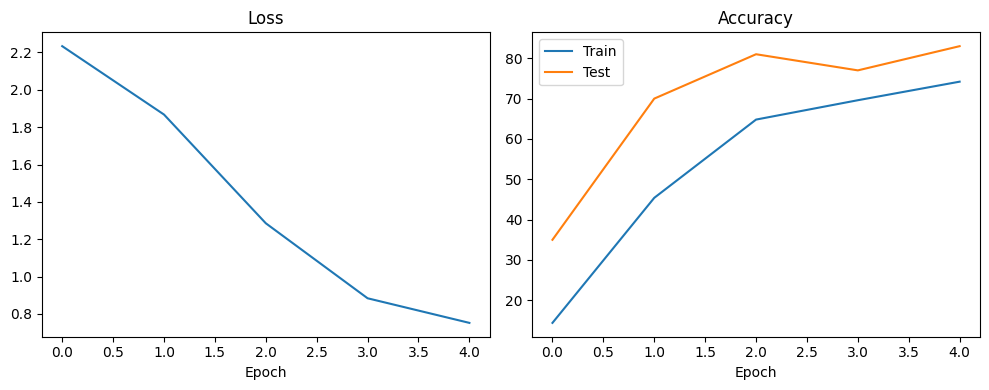

In [9]:
mock_result = request.run_mock()
print(f"Mock accuracy: {mock_result.data.public.get('test_accuracy', 'N/A')}")
mock_result.data.show_figures("public")

## Step 7: Run Real Training

In [ ]:
# Update progress before starting
progress.value = {"epoch": 0, "total_epochs": 5, "status": "starting"}

# Run the DS's training function on our real data
# The on_progress callback will be called during training!
result = request.run()

# Update progress with final results
if result.data.private:
    final = result.data.private
    progress.value = {
        "epoch": 5,
        "total_epochs": 5,
        "status": "complete",
        "train_acc": round(final.get('train_accuracy', 0), 2),
        "test_acc": round(final.get('test_accuracy', 0), 2),
    }

print(f"Real accuracy: {result.data.private.get('test_accuracy', 'N/A'):.2f}%")
print(f"Model size: {len(result.data.private.get('model_weights', b''))} bytes")
result.data.show_figures("private")

## Step 8: Approve Results

In [11]:
result.approve()
progress.disable_live()
print("Results approved and sent!")

✅ Approving result for: train_cnn_result (twin_id=1d28cd0df813..., comp_id=470206746e4d..., result_id=1d28cd0df813)
   Sending to: client2@sandbox.local
🔒 Using PRIVATE data from Twin 'train_cnn_result...'
✓ Result sent to session folder: /Users/madhavajay/dev/biovault-desktop/workspace2/biovault/sandbox/client1@sandbox.local/datasites/client1@sandbox.local/shared/biovault/sessions/d9efe11cc2d0
💡 They can load it with: bv.inbox()['train_cnn_result'].load()
⚫ Live sync disabled
Results approved and sent!


## Summary

- Loaded real MNIST and created noisy mock data
- Published live progress tracker
- Ran CNN training on real data
- DS only received accuracy and training curves, never raw data!